In [1]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import ticker
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress, pearsonr, spearmanr
import nibabel as nib
import urllib
import seaborn as sns
sns.set_context('notebook', font_scale=2)
sns.set_style('white')


### Read in the phenotypic behavioural data

This is the **Phenotypic_V1_0b_preprocessed1.csv** file. It's saved in the **DATA** folder.

You can find the explanations of all the columns in the **ABIDE_LEGEND_V1.02.pdf** file.

We're going to load the data into a pandas data frame.

In [2]:
behav_data_f = '../../Phenotypic_V1_0b_preprocessed1.csv'
df = pd.read_csv(behav_data_f)

Our measure of interest is **func_perc_fd** so lets get rid of all participants who don't have a value!

We also want to make sure our data **has the data** so lets get rid of all participants who's file ID is "no_filename".

We also want to know the **age in years** for each participant.

In [3]:
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])

### Create a stratified sample

We want to see how similar the average connectivity values are ***when there are no differences between the groups***.

Therefore we need to split participants into ***matched*** samples.

What do they need to be matched on?!

* DSM_IV_TR -- their diagnosis according to the DSM IV (0: control, 1: ASD, 2: Asp, 3: PDD)
* SITE_ID -- the scanning site
* AGE_YRS -- age in years
* SEX -- sex (1: male, 2: female)



### Threshold your sample according to the motion/age cut offs

We're going to systematically change the upper threshold of the percent of volumes that exceed 0.2mm frame to frame dispacement.

And we're also going to select our lower and upper age limits. NOTE that these are inclusive boundaries. So for example a lower limit of 6 and an upper limit of 10 will include participants who are 6, 7, 8, 9 and 10 years old.

* func_perc_fd
* AGE_YRS

In [4]:
motion_thresh = 80
df_samp_motion = df.loc[df['func_perc_fd']<motion_thresh, :]

In [5]:
age_l, age_u = 6, 18
df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l) & (df_samp_motion['AGE_YRS']<=age_u), :]

### Only keep 2n participants

Where n is the number of participants you're going to put in each group.

Remember to shuffle before you do this so you don't keep the top n participant every time.

In [30]:
n = 30
n_2 = 2*n

df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))
df_samp_2n = df_samp_rand.iloc[:2*n, :]

### Sort according to the matching measures

In [6]:
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort(columns=sort_column_list)

NameError: name 'df_samp_2n' is not defined

### Split this data frame into two and VOILA

In [ ]:
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

### Actually this can be implemented as a function

The inputs to `split_two_matched_samples` are the master data frame (`df`), the motion threshold (`motion_thresh`), lower age limit (`age_l`), upper age limit (`age_u`) and the number of participants (`n`) in each group.

In [19]:
from abide_motion_wrapper_JAL import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 80, 6, 18, 200)

print df_A[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()
print df_B[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()


       AGE_AT_SCAN   DX_GROUP         SEX
count   200.000000  200.00000  200.000000
mean     12.961047    1.45500    1.140000
std       2.893583    0.49922    0.347858
min       7.000000    1.00000    1.000000
25%      10.705000    1.00000    1.000000
50%      12.775000    1.00000    1.000000
75%      15.055000    2.00000    1.000000
max      18.900000    2.00000    2.000000
       AGE_AT_SCAN   DX_GROUP         SEX
count   200.000000  200.00000  200.000000
mean     13.179463    1.45500    1.135000
std       2.941456    0.49922    0.342581
min       7.000000    1.00000    1.000000
25%      10.900000    1.00000    1.000000
50%      13.260000    1.00000    1.000000
75%      15.525000    2.00000    1.000000
max      18.600000    2.00000    2.000000


### Make the individual and group correlation matrices

This function is in one of the files in our repository, but I've added in a little check for NaNs.

***TO DO*** Understand better where these NaNs are coming from!

In [20]:
def make_group_corr_mat(df):
    """
    This function reads in each subject's aal roi time series files and creates roi-roi correlation matrices
    for each subject and then sums them all together. The final output is a 3d matrix of all subjects 
    roi-roi correlations, a mean roi-roi correlation matrix and a roi-roi covariance matrix. 
    **NOTE WELL** This returns correlations transformed by the Fisher z, aka arctanh, function.    
    """

    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        
        # read each subjects aal roi time series files
        ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

        # create a correlation matrix from the roi all time series files
        corr_mat_r = ts_df.corr()
        
        # the correlations need to be transformed to Fisher z, which is
        # equivalent to the arctanh function.
        corr_mat_z = np.arctanh(corr_mat_r)
        
        # for the first subject, create a correlation matrix of zeros
        # that is the same dimensions as the aal roi-roi matrix
        if i == 0:
            all_corr_mat = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], len(df)])

        # now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
        all_corr_mat[:, :, i] = corr_mat_z
    
        # If there are any NaNs then print the subject id
        n_nan = np.sum(np.sum(corr_mat_r.isnull()))
        if n_nan > 0:
            print 'SUB has NaNs: {}'.format(f_id)
            
    # create the mean correlation matrix (ignore nas - sometime there are some...)
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    # create the group covariance matrix (ignore nas - sometime there are some...)
    var_corr_mat = np.nanvar(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, var_corr_mat


Make the group correlation matrices for the two different groups.

Note that the code prints out which subjects have NaNs...

In [21]:
M_grA, M_grA_av, M_grA_var = make_group_corr_mat(df_A)
M_grB, M_grB_av, M_grB_var = make_group_corr_mat(df_B)


/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: KKI_0050790
SUB has NaNs: Pitt_0050045
SUB has NaNs: Pitt_0050035
SUB has NaNs: SDSU_0050195
SUB has NaNs: KKI_0050815
SUB has NaNs: NYU_0051033
SUB has NaNs: Pitt_0050028
SUB has NaNs: Pitt_0050026
SUB has NaNs: SDSU_0050192
SUB has NaNs: SDSU_0050184
SUB has NaNs: Caltech_0051487
SUB has NaNs: Leuven_2_0050727
SUB has NaNs: NYU_0051100
SUB has NaNs: NYU_0051036
SUB has NaNs: Pitt_0050050
SUB has NaNs: KKI_0050793
SUB has NaNs: Pitt_0050011
SUB has NaNs: SDSU_0050182


Reason we have nans is because some people have "0" for aal time series - this could be because they don't have coverage there, etc. For example 'Caltech_0051487' has zero for ROI #9052. 

### Check out the distributions of the r and z values in one of the correlation matrices

Just to see what happens to the data when you apply the `arctanh` transform.

(The answer is: not too much!)

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in arctanh


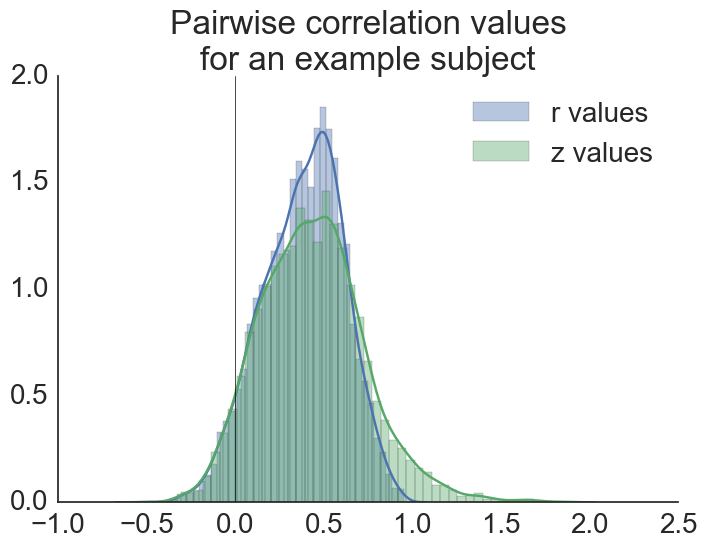

In [22]:
sub, f_id = df[['SUB_ID', 'FILE_ID']].values[0]

ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))
corr_mat_r = ts_df.corr()
corr_mat_z = np.arctanh(corr_mat_r)

r_array = np.triu(corr_mat_r, k=1).reshape(-1)
z_array = np.triu(corr_mat_z, k=1).reshape(-1)
sns.distplot(r_array[r_array<>0.0], label='r values')
sns.distplot(z_array[z_array<>0.0], label='z values')

plt.axvline(c='k', linewidth=0.5)

plt.legend()

plt.title('Pairwise correlation values\nfor an example subject')
sns.despine()

### Visually check the average correlation matrices for the two groups

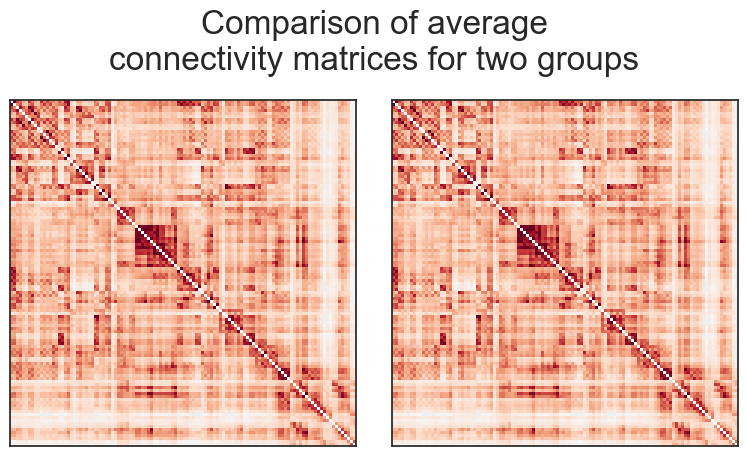

In [23]:
fig, ax_list = plt.subplots(1,2)

ax_list[0].imshow(M_grA_av, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1)
ax_list[1].imshow(M_grB_av, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1)

for ax in ax_list:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.suptitle('Comparison of average\nconnectivity matrices for two groups')

plt.tight_layout()


### Scatter plot of the two connectivity matrices 

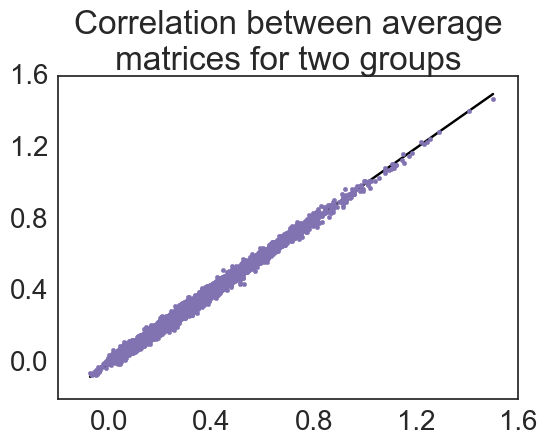

In [24]:
indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = M_grA_av[indices]
grB_values = M_grB_av[indices]

min_val = np.min([np.min(grA_values), np.min(grB_values)])
max_val = np.max([np.max(grA_values), np.max(grB_values)])

fig, ax = plt.subplots(figsize=(6,5))
ax.plot([np.min(grA_values), np.max(grA_values)], [np.min(grA_values), np.max(grA_values)], c='k', zorder=-1)
ax.scatter(grA_values, grB_values, color=sns.color_palette()[3], s=10, edgecolor='face')

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation between average\nmatrices for two groups')
plt.tight_layout()

### Figure out the correlation with age for each row

We can write a little function for this

In [25]:
def corr_w_age(df, M_all):
    # We want to fill in a correlation matrix with the correlation
    # with age for all the roi-roi pairs.
    # We want to know the r, p and m (slope) values:
    # Lets start by making the output arrays
    # (originally filled with zeros)
    age_roi_corr_r =np.zeros((116,116))
    age_roi_corr_p =np.zeros((116,116))
    age_roi_corr_m =np.zeros((116,116))

    # The age for your participants stays the same at all times!
    # So we just need one array with their values
    age=df.loc[:, 'AGE_AT_SCAN'].values

    # BUT we want to loop through all the roi-roi pairs. 
    # There's no need to do the calculation for the bottom part of
    # the triangle as it is symmetric.
    i_list, j_list = np.triu_indices(116, k=1)

    # Now, loop through all the pairs and fill in the pearson
    # correlation for all regions
    for i, j in zip(i_list, j_list):
        age_roi_corr_r[i, j] = pearsonr(M_all[i, j, :], age)[0]
        age_roi_corr_p[i, j] = pearsonr(M_all[i, j, :], age)[1]
        age_roi_corr_m[i, j] = linregress(M_all[i, j, :], age)[0]
    
    # Finally, flip the correlation values to the bottom triangle
    age_roi_corr_r = age_roi_corr_r + age_roi_corr_r.T
    age_roi_corr_p = age_roi_corr_p + age_roi_corr_p.T
    age_roi_corr_m = age_roi_corr_m + age_roi_corr_m.T
    
    
    return age_roi_corr_r, age_roi_corr_p, age_roi_corr_m

### Now actually calculate these correlations for our two groups

In [26]:
age_roi_corr_r_A, age_roi_corr_p_A, age_roi_corr_m_A = corr_w_age(df_A, M_grA)
age_roi_corr_r_B, age_roi_corr_p_B, age_roi_corr_m_B = corr_w_age(df_B, M_grB)


### Now calculate correlations between the two groups

Ignore the Nans for now

In [27]:
indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = age_roi_corr_r_A[indices]
grB_values = age_roi_corr_r_B[indices]
mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

r, p = pearsonr(grA_values[~mask_nans], grB_values[~mask_nans])
r

0.48240266306104929

In [28]:
##how does this differ from spearman r?
r, p = spearmanr(grA_values[~mask_nans], grB_values[~mask_nans])
r

0.45401866269164454

### Plot these correlations

***TO DO***: Sort out the NaNs! That's why we have some empty lines.

what should we do with the NaNs? Ignore them?

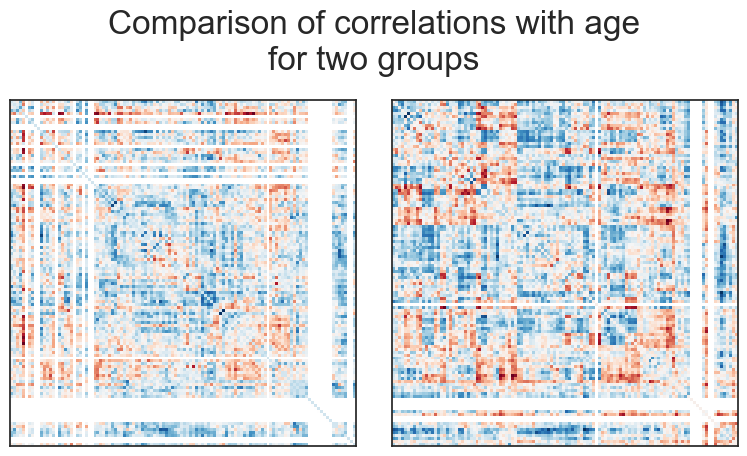

In [29]:
fig, ax_list = plt.subplots(1, 2)

ax_list[0].imshow(age_roi_corr_r_A, interpolation='none',cmap='RdBu_r')# vmin=-0.3, vmax=0.3, )
ax_list[1].imshow(age_roi_corr_r_B, interpolation='none', cmap='RdBu_r') #vmin=-0.3, vmax=0.3, cmap='RdBu_|r')

for ax in ax_list:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.suptitle('Comparison of correlations with age\nfor two groups')

plt.tight_layout()


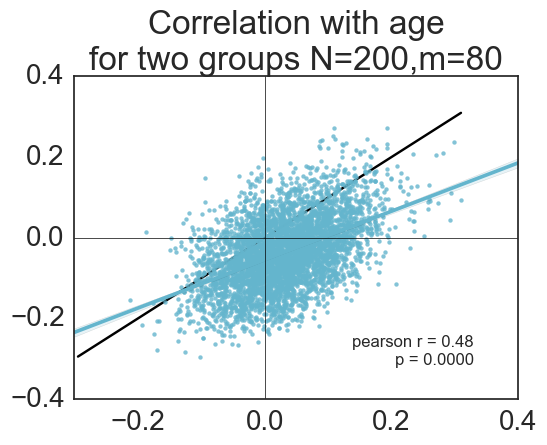

In [30]:
indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = age_roi_corr_r_A[indices]
grB_values = age_roi_corr_r_B[indices]

min_val = np.min([np.nanmin(grA_values), np.nanmin(grB_values)])
max_val = np.max([np.nanmax(grA_values), np.nanmax(grB_values)])

mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(grA_values[~mask_nans],
            grB_values[~mask_nans],
            color = sns.color_palette()[5],
            scatter_kws={'s' : 10, 'edgecolor' : 'face'}, 
            ax=ax)

ax.plot([min_val, max_val], [min_val, max_val], c='k', zorder=-1)

ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation with age\nfor two groups N=200,m=80')

r, p = pearsonr(grA_values[~mask_nans], grB_values[~mask_nans])

ax.text(0.9, 0.1,
        'pearson r = {:2.2f}\np = {:2.4f}'.format(r, p),
        transform=ax.transAxes,
        verticalalignment='bottom',
        horizontalalignment='right',
        fontsize=12)

plt.tight_layout()

### Do this for select sample sizes and motion thresholds!

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: SDSU_0050209
SUB has NaNs: NYU_0051033
SUB has NaNs: Caltech_0051487
SUB has NaNs: Leuven_2_0050727
SUB has NaNs: SDSU_0050195
SUB has NaNs: SDSU_0050210
SUB has NaNs: Pitt_0050011
SUB has NaNs: SDSU_0050216


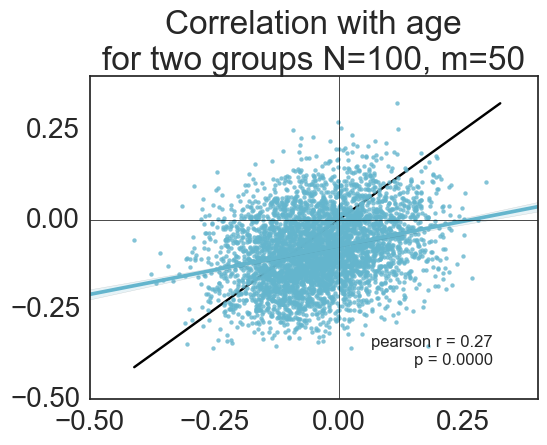

In [13]:
from abide_motion_wrapper_JAL import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 50, 6, 18, 100)

M_grA, M_grA_av, M_grA_var = make_group_corr_mat(df_A)
M_grB, M_grB_av, M_grB_var = make_group_corr_mat(df_B)

age_roi_corr_r_A, age_roi_corr_p_A, age_roi_corr_m_A = corr_w_age(df_A, M_grA)
age_roi_corr_r_B, age_roi_corr_p_B, age_roi_corr_m_B = corr_w_age(df_B, M_grB)

indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = age_roi_corr_r_A[indices]
grB_values = age_roi_corr_r_B[indices]

min_val = np.min([np.nanmin(grA_values), np.nanmin(grB_values)])
max_val = np.max([np.nanmax(grA_values), np.nanmax(grB_values)])

mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(grA_values[~mask_nans],
            grB_values[~mask_nans],
            color = sns.color_palette()[5],
            scatter_kws={'s' : 10, 'edgecolor' : 'face'}, 
            ax=ax)

ax.plot([min_val, max_val], [min_val, max_val], c='k', zorder=-1)

ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation with age\nfor two groups N=100, m=50')

r, p = pearsonr(grA_values[~mask_nans], grB_values[~mask_nans])

ax.text(0.9, 0.1,
        'pearson r = {:2.2f}\np = {:2.4f}'.format(r, p),
        transform=ax.transAxes,
        verticalalignment='bottom',
        horizontalalignment='right',
        fontsize=12)

plt.tight_layout()

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: SDSU_0050209
SUB has NaNs: SDSU_0050210
SUB has NaNs: SDSU_0050184
SUB has NaNs: KKI_0050790
SUB has NaNs: SDSU_0050195
SUB has NaNs: SDSU_0050182


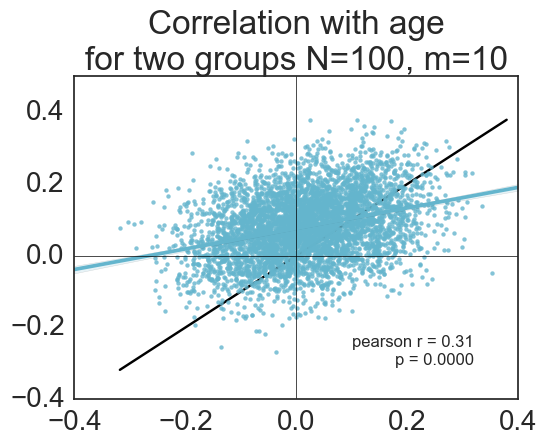

In [14]:
from abide_motion_wrapper_JAL import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 10, 6, 18, 100)

M_grA, M_grA_av, M_grA_var = make_group_corr_mat(df_A)
M_grB, M_grB_av, M_grB_var = make_group_corr_mat(df_B)

age_roi_corr_r_A, age_roi_corr_p_A, age_roi_corr_m_A = corr_w_age(df_A, M_grA)
age_roi_corr_r_B, age_roi_corr_p_B, age_roi_corr_m_B = corr_w_age(df_B, M_grB)

indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = age_roi_corr_r_A[indices]
grB_values = age_roi_corr_r_B[indices]

min_val = np.min([np.nanmin(grA_values), np.nanmin(grB_values)])
max_val = np.max([np.nanmax(grA_values), np.nanmax(grB_values)])

mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(grA_values[~mask_nans],
            grB_values[~mask_nans],
            color = sns.color_palette()[5],
            scatter_kws={'s' : 10, 'edgecolor' : 'face'}, 
            ax=ax)

ax.plot([min_val, max_val], [min_val, max_val], c='k', zorder=-1)

ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation with age\nfor two groups N=100, m=10')

r, p = pearsonr(grA_values[~mask_nans], grB_values[~mask_nans])

ax.text(0.9, 0.1,
        'pearson r = {:2.2f}\np = {:2.4f}'.format(r, p),
        transform=ax.transAxes,
        verticalalignment='bottom',
        horizontalalignment='right',
        fontsize=12)

plt.tight_layout()

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: SDSU_0050210
SUB has NaNs: Pitt_0050007


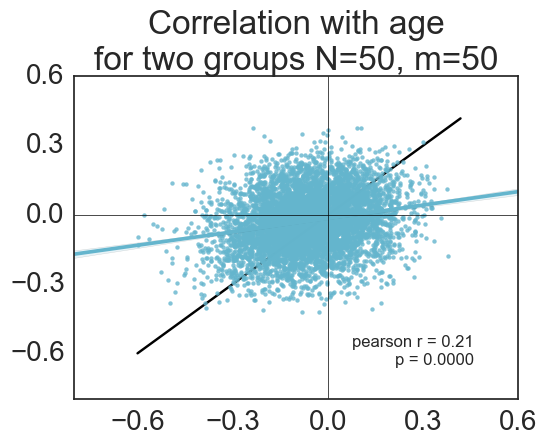

In [16]:
from abide_motion_wrapper_JAL import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 50, 6, 18, 50)

M_grA, M_grA_av, M_grA_var = make_group_corr_mat(df_A)
M_grB, M_grB_av, M_grB_var = make_group_corr_mat(df_B)

age_roi_corr_r_A, age_roi_corr_p_A, age_roi_corr_m_A = corr_w_age(df_A, M_grA)
age_roi_corr_r_B, age_roi_corr_p_B, age_roi_corr_m_B = corr_w_age(df_B, M_grB)

indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = age_roi_corr_r_A[indices]
grB_values = age_roi_corr_r_B[indices]

min_val = np.min([np.nanmin(grA_values), np.nanmin(grB_values)])
max_val = np.max([np.nanmax(grA_values), np.nanmax(grB_values)])

mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(grA_values[~mask_nans],
            grB_values[~mask_nans],
            color = sns.color_palette()[5],
            scatter_kws={'s' : 10, 'edgecolor' : 'face'}, 
            ax=ax)

ax.plot([min_val, max_val], [min_val, max_val], c='k', zorder=-1)

ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation with age\nfor two groups N=50, m=50')

r, p = pearsonr(grA_values[~mask_nans], grB_values[~mask_nans])

ax.text(0.9, 0.1,
        'pearson r = {:2.2f}\np = {:2.4f}'.format(r, p),
        transform=ax.transAxes,
        verticalalignment='bottom',
        horizontalalignment='right',
        fontsize=12)

plt.tight_layout()

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: Caltech_0051487


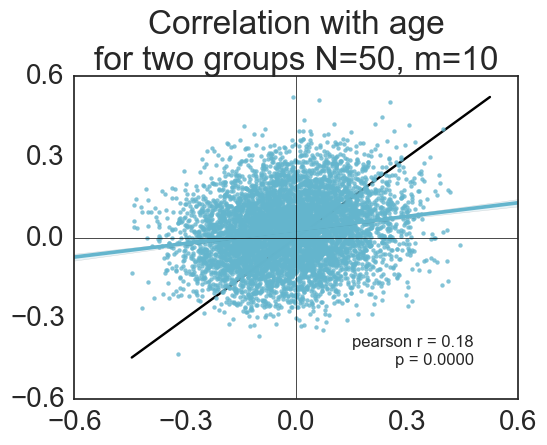

In [17]:
from abide_motion_wrapper_JAL import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 10, 6, 18, 50)

M_grA, M_grA_av, M_grA_var = make_group_corr_mat(df_A)
M_grB, M_grB_av, M_grB_var = make_group_corr_mat(df_B)

age_roi_corr_r_A, age_roi_corr_p_A, age_roi_corr_m_A = corr_w_age(df_A, M_grA)
age_roi_corr_r_B, age_roi_corr_p_B, age_roi_corr_m_B = corr_w_age(df_B, M_grB)

indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = age_roi_corr_r_A[indices]
grB_values = age_roi_corr_r_B[indices]

min_val = np.min([np.nanmin(grA_values), np.nanmin(grB_values)])
max_val = np.max([np.nanmax(grA_values), np.nanmax(grB_values)])

mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(grA_values[~mask_nans],
            grB_values[~mask_nans],
            color = sns.color_palette()[5],
            scatter_kws={'s' : 10, 'edgecolor' : 'face'}, 
            ax=ax)

ax.plot([min_val, max_val], [min_val, max_val], c='k', zorder=-1)

ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation with age\nfor two groups N=50, m=10')

r, p = pearsonr(grA_values[~mask_nans], grB_values[~mask_nans])

ax.text(0.9, 0.1,
        'pearson r = {:2.2f}\np = {:2.4f}'.format(r, p),
        transform=ax.transAxes,
        verticalalignment='bottom',
        horizontalalignment='right',
        fontsize=12)

plt.tight_layout()